## Acquire images

This notebook will:

* Section 1: For a given bounding box and year, find all SAR images in that region. Get some stats on them
* Section 2: Filter out images from scenes that don't have sufficient preceding winter imagery for melt detection
* Section 3: Run ASF Hyp3 RTC processing
* Section 4: Download the data. Reproject it immedately and save only the smaller image. Does that work? I thought I would have to have EPSG vals? This will have to get figured out

### Preamble
Prepare to do stuff

In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX

#capture
from datetime import datetime
import glob
import json # for loads
import os
from pathlib import Path
import pytz
import re
import shutil
import asf_search as asf
from zipfile import ZipFile
import time
import fnmatch

from matplotlib import pyplot as plt
#Writing Support Functions:

import numpy as np
from osgeo import gdal,osr

from IPython.display import HTML, display, clear_output, Markdown
    
from hyp3_sdk import Batch, HyP3

import opensarlab_lib as asfn

URLWidget()

In [2]:
##NAME PROJECT###
projdir = Path.home()
projname = 'Kenn'
year = 2020
data_dir=Path(f'{projdir}/{projname}/{str(year)}')
pols = ['VV','VH']

# Setting Paths
analysis_directory = Path.cwd()/data_dir
print(f"analysis_directory: {analysis_directory}")

download_path = analysis_directory/"rtc_download"
# download_path.mkdir()
products_path = analysis_directory/"rtc_products"
# products_path.mkdir()
clipped_path = analysis_directory/"rtc_clipped"

print(download_path)
print(products_path)
print(clipped_path)

os.makedirs(data_dir,exist_ok=True)
os.makedirs(download_path,exist_ok=True)
os.makedirs(products_path,exist_ok=True)
os.makedirs(analysis_directory/"figures",exist_ok=True)
os.makedirs(clipped_path,exist_ok=True)
for pol in pols:
    os.makedirs(clipped_path/pol,exist_ok=True)

# print(os.path.exists(data_dir))

analysis_directory: /home/jovyan/Kenn/2020
/home/jovyan/Kenn/2020/rtc_download
/home/jovyan/Kenn/2020/rtc_products
/home/jovyan/Kenn/2020/rtc_clipped


In [3]:
def timediff(time1,time2,form='seconds'):
    '''time difference between time2 and time1 expressed as either days or seconds'''
    # dd = 1
    # if time1>time2:
    #     dd=1
    diff = time2-time1
    if form=='seconds':
        diff = diff.seconds+diff.days*86400
    elif form=='days':
        diff = diff.seconds/86400+diff.days
    return diff

## Find SAR Images

Find the SAR images, run some statistics on their frequency, and queue them for Hyp3 processing

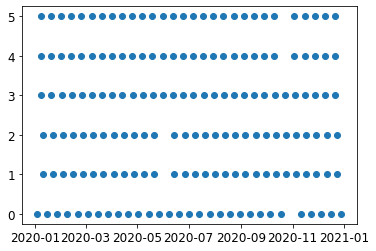

In [4]:
#testpolygon = POLYGON((-143.1356 61.7756,-143.3698 61.7793,-143.5279 61.7044,-143.3824 61.6052,-143.0614 61.4737,-142.9854 61.4144,-142.804 61.4292,-142.7358 61.5912,-142.5978 61.6494,-142.6707 61.7523,-142.9699 61.7839,-143.1356 61.7756))
WTKstr='POLYGON((-143.4858 61.4239,-142.5307 61.4239,-142.5307 61.7757,-143.4858 61.7757,-143.4858 61.4239))' #Kennicott
# testWTK='POLYGON((-134.5463 58.5889,-133.8663 58.5889,-133.8663 58.7656,-134.5463 58.7656,-134.5463 58.5889))' #SE AK icefield
# testWTK='POLYGON((-18.2664 63.9706,-15.2442 63.9706,-15.2442 64.9461,-18.2664 64.9461,-18.2664 63.9706))' #iceland
# testWTK='POLYGON((15.123 78.0197,16.9688 78.0197,16.9688 78.2449,15.123 78.2449,15.123 78.0197))' #svalbard
# testWTK = 'POLYGON((-140.264 60.3786,-140.0853 60.3786,-140.0853 60.4539,-140.264 60.4539,-140.264 60.3786))'
# testWTK='POLYGON((-50.0733 70.6347,-47.6859 70.6347,-47.6859 71.1109,-50.0733 71.1109,-50.0733 70.6347))' #west greenland

# year = 2020
results = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1], intersectsWith=WTKstr, maxResults=1000,start=f'{year}-01-01',
                         end=f'{year+1}-01-01',processingLevel='SLC')

datelist = []
pflist = [] #path-frame list
for res in results:
    res = res.properties
    rdate = datetime.strptime(res['startTime'],'%Y-%m-%dT%H:%M:%S.%f')
    rpf = res['pathNumber']+'-'+res['frameNumber']
    res['datetime']=rdate
    res['pfval'] = rpf
    datelist.append(rdate)
    pflist.append(rpf)

    
pfunique = np.unique(pflist)
pfvals = pflist
pflist = [np.where(pfunique==i)[0][0] for i in pflist]

plt.figure()
plt.plot(datelist,pflist,'.',markersize=12)

In [17]:
# help(results[0])
# results[0].properties

total removed: 0


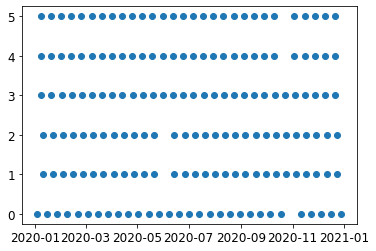

In [5]:
#remove images that have less than N winter scenes

N=4
wstart = datetime(year,1,1,0,0,0)
wend = datetime(year,4,1,1,0,0,0)
#result2 = results
pfremove=[]
trem = 0
#identify path-frames that do not meet requirements
for pf in pfunique:
    eles = [i for i in results if i.properties['pfval']==pf]
    datelist = np.array([i.properties['datetime'] for i in eles])
    dl2 = datelist[datelist > wstart]
    dl2 = dl2[dl2 < wend]
    if len(dl2)<N:
        pfremove.append(pf)
        trem += len(datelist)

#remove images from those path-frames
for res in results:
    if res.properties['pfval'] in pfremove:
        results.remove(res)
            
print(f'total removed: {trem}')
# print(pfremove)

#now plot again:
datelist = [i.properties['datetime'] for i in results]
pflist = [i.properties['pfval'] for i in results]
pfunique = np.unique(pflist)
pflist = [np.where(pfunique==i)[0][0] for i in pflist]

plt.figure()
plt.plot(datelist,pflist,'.',markersize=12)

In [18]:
#Give more stats:

dlsort = [i for i in datelist]
dlsort.sort()
dldelta = [timediff(dlsort[i],dlsort[i+1],form='days') for i in range(len(dlsort)-1)]
dldelta = np.array(dldelta)

print('Acquisition stats')
print(f'Number of acquisitions:       {len(dldelta)+1}')
print(f'Number of images >1min apart: {len(dldelta[dldelta>1/1440])+1}\n')
print(f'Mean days apart:   {np.mean(dldelta):.3f}')
print(f'Mean days >1min:   {np.mean(dldelta[dldelta>1/1440]):.3f}')
print(f'Median days apart: {np.median(dldelta):.3f}')
print(f'Median days >1min: {np.median(dldelta[dldelta>1/1440]):.3f}')
print(f'Stdev days apart:  {np.std(dldelta):.3f}')
print(f'Longest gap:       {np.max(dldelta):.3f}')
print('Note: these are over the whole area, not necessarily by pixel')

Acquisition stats
Number of acquisitions:       176
Number of images >1min apart: 118

Mean days apart:   2.057
Mean days >1min:   3.077
Median days apart: 1.463
Median days >1min: 4.480
Stdev days apart:  2.296
Longest gap:       10.011
Note: these are over the whole area, not necessarily by pixel


## Do Hyp3 Processing

In [7]:
hyp3 = HyP3(prompt=True)

NASA Earthdata Login username:  acjohnson16
NASA Earthdata Login password:  ·········


In [22]:
test = hyp3.find_jobs()
print(len(test))
# print(test[50].download_files)

test2 = hyp3.my_info()
print(test2)

419
{'job_names': ['BSI_test2', 'BSI_test3', 'Greenland_test1', 'Hidden Lake Single', 'Kenn_20_notebook', 'Kenn_21_alt', 'Kenn_21_full', 'Kenn_21_notebook', 'Kennicott_21', 'Kennicott_Dec20', 'Kennicott_Jul21_test', 'LarsenC Single', 'Ronne_July21', 'Utk_test1', 'Wilkins Apr_17'], 'quota': {'max_jobs_per_month': 1000, 'remaining': 824}, 'user_id': 'acjohnson16'}


In [11]:
#Submit jobs for RTC processing

projectname = 'Kenn_20_notebook_2'

granules = [i.properties['sceneName'] for i in results]
# print(granules)
# help(hyp3.submit_rtc_job)
submitjobs = True
if submitjobs:
    rtc_jobs = Batch()
    for g in granules:
        rtc_jobs += hyp3.submit_rtc_job(g, name=projectname)
    print(rtc_jobs)

176 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 176 pending.


In [16]:
#do failed job: S1A_IW_SLC__1SDV_20210701T155634_20210701T155701_038586_048D97_C318
dofailedjob = False
if dofailedjob:
    hyp3.submit_rtc_job('S1A_IW_SLC__1SDV_20210701T155634_20210701T155701_038586_048D97_C318', name = projectname)

In [140]:
# Display Hyp3 job info
print(rtc_jobs)
print(hyp3.my_info())

173 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 173 pending.
0 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 0 pending.
{'job_names': ['BSI_test2', 'BSI_test3', 'Greenland_test1', 'Hidden Lake Single', 'Kenn_21_alt', 'Kenn_21_full', 'Kenn_21_notebook', 'Kennicott_21', 'Kennicott_Dec20', 'Kennicott_Jul21_test', 'LarsenC Single', 'Ronne_July21', 'Utk_test1', 'Wilkins Apr_17'], 'quota': {'max_jobs_per_month': 1000, 'remaining': 827}, 'user_id': 'acjohnson16'}


In [17]:
hyp3.my_info()

{'job_names': ['BSI_test2',
  'BSI_test3',
  'Greenland_test1',
  'Hidden Lake Single',
  'Kenn_21_alt',
  'Kenn_21_full',
  'Kenn_21_notebook',
  'Kennicott_21',
  'Kennicott_Dec20',
  'Kennicott_Jul21_test',
  'LarsenC Single',
  'Ronne_July21',
  'Utk_test1',
  'Wilkins Apr_17'],
 'quota': {'max_jobs_per_month': 1000, 'remaining': 826},
 'user_id': 'acjohnson16'}

## Utility Functions

download images\
extract images\
reproject and clip to wtk\
convert to db\
do this sequentially

In [8]:
#convert utility
def converttodb(file):
    ds = gdal.Open(file, gdal.GA_Update)
    data = ds.ReadAsArray()

    data[data<1e-6]=1e-6
    
    data = 10*np.log10(data)
    data[data==-np.inf]=-60
    ds.GetRasterBand(1).WriteArray(data)
    ds = None

#download utility:
def extracttif(inloc,outloc,pol='VV',convert=True):
    """expect pol to be 'VV','VH','HH', or 'HV' 
    convert will convert this to db"""
    if str(inloc)[-1]!='/':
        inloc = str(inloc)+'/'
    if str(outloc)[-1]!='/':
        outloc = str(outloc)+'/'
    infile = glob.glob(f'{inloc}*')
    endstr = pol+'.tif'
    for file in infile:
        # print(file)
        # namelist = 
        with ZipFile(file) as z:
            # print(z.namelist)
            z = ZipFile(file)
            zname = [name for name in z.namelist() if name[-6:]==endstr][0]
            # z.extract()
        
            filename = os.path.basename(zname)
            source = z.open(zname)
            targetname = os.path.join(outloc, filename)
            target = open(targetname, "wb")
            with source, target:
                shutil.copyfileobj(source, target)
            target.close()
            if convert:
                converttodb(targetname)
        # os.remove(file)
        

In [9]:
#CLIPPING TOOLS

def wtkparse(wtk):
    """It's not weird if it works"""
    wtk = wtk.split("'")
    wtk = wtk[0].split("(")[2]
    wtk = wtk.split(")")[0]
    wtk = wtk.split(',')
    wtk = [s.split(' ') for s in wtk]
    wtk = np.array([[float(ss) for ss in s] for s in wtk])
    return(wtk)

def CoordConvert(points,inproj,outproj,ptparse=False):
    """Convert coordinate grid from one projection to another
    if converting from 4326, then points should be ordered lon,lat"""

    if ptparse:
        points = wtkparse(points)

    if type(inproj)==str:
        inproj=int(inproj)
    if type(outproj)==str:
        outproj=int(outproj)

    epsgin = osr.SpatialReference()
    epsgin.ImportFromEPSG(inproj)   
    epsgout = osr.SpatialReference()
    epsgout.ImportFromEPSG(outproj)

    convert = osr.CoordinateTransformation(epsgin, epsgout)
    points = np.array(points)
    
    for i,x in enumerate(points):
        newpt = convert.TransformPoint(x[1],x[0])
        points[i,0],points[i,1]=newpt[0],newpt[1]
        
    return points

def wtktobox(wtk,epsgn,srcproj = 4326):
    """epsgn is the epsg of the tif file
    output will be ulx uly lrx lry"""
    epsgn = int(epsgn)
    srcproj = int(srcproj)
    xyp = CoordConvert(wtk,4326,epsgn,ptparse=True)
    ulx,uly = np.min(xyp[:,0]),np.max(xyp[:,1])
    lrx,lry = np.max(xyp[:,0]),np.min(xyp[:,1])
    return ulx,uly,lrx,lry

def testEPSG(inloc):
    if str(inloc)[-1]!='/':
        inloc = str(inloc)+'/'
    # if str(outloc)[-1]!='/':
        # outloc = str(outloc)+'/'
    infiles = glob.glob(f'{inloc}*')
    for file in infiles:
        ds=gdal.Open(file)
        proj = osr.SpatialReference(wkt=ds.GetProjection())
        dsproj = proj.GetAttrValue('AUTHORITY',1)
        ds = None
        print(dsproj)
# testEPSG(products_path)

def getEPSG(file):
    ds=gdal.Open(file)
    proj = osr.SpatialReference(wkt=ds.GetProjection())
    dsproj = proj.GetAttrValue('AUTHORITY',1)
    ds = None
    return dsproj

def identify_epsgs(fileloc):
    """Identify EPSG systems used in this. By default this will return the most commonly one."""
    if str(fileloc)[-1]!='/':
        fileloc = str(fileloc)+'/'
    filelist = glob.glob(f'{fileloc}*')
    eplist = []
    for file in filelist:
        eplist.append(getEPSG(file))
        # print(eplist[-1])
        # print(file)
    epu,epc = np.unique(eplist,return_counts=True)
    for i,ep in enumerate(epu):
        count = epc[i]
        print(f'Found EPSG:{ep}, count: {count}')
    return epu[np.where(epc==np.max(epc))[0]][0]

def reproject(wtk,epsgn,inloc,outloc,res=30,convert_to_db=False):
    """make the magic happen"""
    if str(inloc)[-1]!='/':
        inloc = str(inloc)+'/'
    if str(outloc)[-1]!='/':
        outloc = str(outloc)+'/'
    infiles = glob.glob(f'{inloc}*')
    
    epsgn = int(epsgn)
    ulx,uly,lrx,lry = wtktobox(wtk,epsgn)
    # c1=0
    epsgns = f'ESPG:{str(epsgn)}'
    for file in infiles:
        ofile = file.replace(inloc,outloc)
        # ofile = '/home/jovyan/test/rtc_clipped/S1B_IW_20210713T031944_DVP_RTC30_G_gpuned_1E76_VV'
        epsgf = int(getEPSG(file))
        epsgfs = f'ESPG:{str(epsgf)}'
        src = gdal.Open(file)
        # print(ofile)
        # print(type(ofile))
        
        epsgo = osr.SpatialReference()
        epsgo.ImportFromEPSG(epsgn)   
        
        gdal.Warp(destNameOrDestDS=ofile,srcDSOrSrcDSTab=src,dstSRS=epsgo,
                  outputBounds=(ulx,lry,lrx,uly),outputBoundsSRS=epsgo,resampleAlg='near',
                  xRes=res,yRes=res)
        
        if convert_to_db:
            converttodb(ofile)

## Get Data

In [13]:
#Download the products, unzip them into the rtc_download directory, convert them to dB, and delete the zip files:
projectname = 'Kenn_20_notebook_2'
EPSGn = '32607'
pols = ['VV','VH']

joblist = hyp3.find_jobs(name=projectname)
joblen = len(joblist)-1
# jobi=0
t = time.time()
for i,job in enumerate(joblist):
    if job.succeeded()==True:
        if i%10 ==1:
            te = time.time()-t
            print(f'Current job: {i}/{joblen}, time elapsed: {te/60:.2f} min, time remaining: {(te/(i+1)*(joblen-i))/60:.2f} min')
        job.download_files(download_path)
        for pol in pols:
            # print(pol)
            extracttif(download_path,products_path,pol=pol,convert=False)
            # fulltif = glob.glob(f'{str(products_path)}/*{pol}*')
            reproject(WTKstr,EPSGn,products_path,f'{str(clipped_path)}/{pol}',convert_to_db=True)
            os.system(f'rm {str(products_path)}/*.tif')
            time.sleep(3)
        os.system(f'rm {str(download_path)}/*.zip')
            # extracttif(download_path,products_path,'VH',convert=True)
    else:
        print(f'WARNING: job {i} did not succeed')

S1A_IW_20200103T154806_DVP_RTC30_G_gpuned_8BB4.zip:   0%|          | 0/453042135 [00:00<?, ?it/s]

Current job: 1/175, time elapsed: 0.35 min, time remaining: 30.49 min


S1B_IW_20200108T031906_DVP_RTC30_G_gpuned_D132.zip:   0%|          | 0/503990326 [00:00<?, ?it/s]

S1A_IW_20200108T155624_DVP_RTC30_G_gpuned_2427.zip:   0%|          | 0/451840731 [00:00<?, ?it/s]

S1B_IW_20200108T031934_DVP_RTC30_G_gpuned_8A97.zip:   0%|          | 0/468993102 [00:00<?, ?it/s]

S1B_IW_20200110T030250_DVP_RTC30_G_gpuned_9A50.zip:   0%|          | 0/472225791 [00:00<?, ?it/s]

S1A_IW_20200115T154805_DVP_RTC30_G_gpuned_4D9C.zip:   0%|          | 0/453398591 [00:00<?, ?it/s]

S1B_IW_20200110T030316_DVP_RTC30_G_gpuned_5532.zip:   0%|          | 0/450569196 [00:00<?, ?it/s]

S1B_IW_20200120T031906_DVP_RTC30_G_gpuned_99B9.zip:   0%|          | 0/503380448 [00:00<?, ?it/s]

S1B_IW_20200120T031933_DVP_RTC30_G_gpuned_CE56.zip:   0%|          | 0/469216686 [00:00<?, ?it/s]

S1A_IW_20200120T155623_DVP_RTC30_G_gpuned_384C.zip:   0%|          | 0/451933761 [00:00<?, ?it/s]

S1B_IW_20200122T030315_DVP_RTC30_G_gpuned_2003.zip:   0%|          | 0/450009685 [00:00<?, ?it/s]

Current job: 11/175, time elapsed: 3.58 min, time remaining: 48.95 min


S1B_IW_20200122T030249_DVP_RTC30_G_gpuned_E862.zip:   0%|          | 0/472154606 [00:00<?, ?it/s]

S1A_IW_20200127T154805_DVP_RTC30_G_gpuned_B9E9.zip:   0%|          | 0/453922771 [00:00<?, ?it/s]

S1B_IW_20200201T031905_DVP_RTC30_G_gpuned_2799.zip:   0%|          | 0/503602659 [00:00<?, ?it/s]

S1B_IW_20200201T031933_DVP_RTC30_G_gpuned_57F7.zip:   0%|          | 0/468794815 [00:00<?, ?it/s]

S1A_IW_20200201T155623_DVP_RTC30_G_gpuned_39BC.zip:   0%|          | 0/451885056 [00:00<?, ?it/s]

S1B_IW_20200203T030249_DVP_RTC30_G_gpuned_94EF.zip:   0%|          | 0/472140265 [00:00<?, ?it/s]

S1B_IW_20200203T030315_DVP_RTC30_G_gpuned_FF61.zip:   0%|          | 0/450105416 [00:00<?, ?it/s]

S1A_IW_20200208T154805_DVP_RTC30_G_gpuned_72C7.zip:   0%|          | 0/452845292 [00:00<?, ?it/s]

S1B_IW_20200213T031933_DVP_RTC30_G_gpuned_316A.zip:   0%|          | 0/468576700 [00:00<?, ?it/s]

S1B_IW_20200213T031905_DVP_RTC30_G_gpuned_B97E.zip:   0%|          | 0/503183518 [00:00<?, ?it/s]

Current job: 21/175, time elapsed: 6.87 min, time remaining: 48.07 min


S1A_IW_20200213T155623_DVP_RTC30_G_gpuned_B17C.zip:   0%|          | 0/451591531 [00:00<?, ?it/s]

S1B_IW_20200215T030249_DVP_RTC30_G_gpuned_EFC2.zip:   0%|          | 0/472053468 [00:00<?, ?it/s]

S1B_IW_20200215T030315_DVP_RTC30_G_gpuned_1AB1.zip:   0%|          | 0/450012635 [00:00<?, ?it/s]

S1A_IW_20200220T154804_DVP_RTC30_G_gpuned_E774.zip:   0%|          | 0/452834569 [00:00<?, ?it/s]

S1B_IW_20200225T031932_DVP_RTC30_G_gpuned_33A0.zip:   0%|          | 0/468455003 [00:00<?, ?it/s]

S1B_IW_20200225T031905_DVP_RTC30_G_gpuned_43C6.zip:   0%|          | 0/503575634 [00:00<?, ?it/s]

S1B_IW_20200227T030248_DVP_RTC30_G_gpuned_80EF.zip:   0%|          | 0/472028371 [00:00<?, ?it/s]

S1A_IW_20200225T155622_DVP_RTC30_G_gpuned_039E.zip:   0%|          | 0/451811920 [00:00<?, ?it/s]

S1B_IW_20200227T030314_DVP_RTC30_G_gpuned_7D25.zip:   0%|          | 0/449230520 [00:00<?, ?it/s]

S1B_IW_20200308T031905_DVP_RTC30_G_gpuned_0C74.zip:   0%|          | 0/504036520 [00:00<?, ?it/s]

Current job: 31/175, time elapsed: 10.24 min, time remaining: 46.08 min


S1A_IW_20200303T154804_DVP_RTC30_G_gpuned_0230.zip:   0%|          | 0/452954956 [00:00<?, ?it/s]

S1A_IW_20200308T155623_DVP_RTC30_G_gpuned_EA40.zip:   0%|          | 0/451608535 [00:00<?, ?it/s]

S1B_IW_20200308T031932_DVP_RTC30_G_gpuned_8352.zip:   0%|          | 0/468518527 [00:00<?, ?it/s]

S1B_IW_20200310T030249_DVP_RTC30_G_gpuned_CA02.zip:   0%|          | 0/471997949 [00:00<?, ?it/s]

S1A_IW_20200315T154804_DVP_RTC30_G_gpuned_E70F.zip:   0%|          | 0/452830452 [00:00<?, ?it/s]

S1B_IW_20200310T030314_DVP_RTC30_G_gpuned_BC49.zip:   0%|          | 0/448927209 [00:00<?, ?it/s]

S1B_IW_20200320T031905_DVP_RTC30_G_gpuned_6ED5.zip:   0%|          | 0/503842982 [00:00<?, ?it/s]

S1A_IW_20200320T155623_DVP_RTC30_G_gpuned_899F.zip:   0%|          | 0/451827921 [00:00<?, ?it/s]

S1B_IW_20200320T031933_DVP_RTC30_G_gpuned_2237.zip:   0%|          | 0/469060251 [00:00<?, ?it/s]

S1B_IW_20200322T030249_DVP_RTC30_G_gpuned_C476.zip:   0%|          | 0/472218258 [00:00<?, ?it/s]

Current job: 41/175, time elapsed: 13.53 min, time remaining: 43.15 min


S1B_IW_20200322T030315_DVP_RTC30_G_gpuned_9F7B.zip:   0%|          | 0/449527344 [00:00<?, ?it/s]

S1A_IW_20200327T154805_DVP_RTC30_G_gpuned_06CA.zip:   0%|          | 0/452777457 [00:00<?, ?it/s]

S1B_IW_20200401T031933_DVP_RTC30_G_gpuned_EBAD.zip:   0%|          | 0/467947009 [00:00<?, ?it/s]

S1B_IW_20200401T031905_DVP_RTC30_G_gpuned_D034.zip:   0%|          | 0/503421672 [00:00<?, ?it/s]

S1A_IW_20200401T155623_DVP_RTC30_G_gpuned_F21A.zip:   0%|          | 0/451728650 [00:00<?, ?it/s]

S1B_IW_20200403T030249_DVP_RTC30_G_gpuned_D840.zip:   0%|          | 0/472179035 [00:00<?, ?it/s]

S1B_IW_20200403T030315_DVP_RTC30_G_gpuned_EF3D.zip:   0%|          | 0/450557052 [00:00<?, ?it/s]

S1A_IW_20200408T154805_DVP_RTC30_G_gpuned_7251.zip:   0%|          | 0/452506429 [00:00<?, ?it/s]

S1B_IW_20200413T031906_DVP_RTC30_G_gpuned_2F1A.zip:   0%|          | 0/503616659 [00:00<?, ?it/s]

S1A_IW_20200413T155623_DVP_RTC30_G_gpuned_52D9.zip:   0%|          | 0/453027283 [00:00<?, ?it/s]

Current job: 51/175, time elapsed: 16.80 min, time remaining: 40.07 min


S1B_IW_20200413T031933_DVP_RTC30_G_gpuned_89D5.zip:   0%|          | 0/470241869 [00:00<?, ?it/s]

S1B_IW_20200415T030250_DVP_RTC30_G_gpuned_9868.zip:   0%|          | 0/474318425 [00:00<?, ?it/s]

S1B_IW_20200415T030315_DVP_RTC30_G_gpuned_DDF5.zip:   0%|          | 0/454088975 [00:00<?, ?it/s]

S1A_IW_20200420T154805_DVP_RTC30_G_gpuned_2232.zip:   0%|          | 0/455163892 [00:00<?, ?it/s]

S1B_IW_20200425T031906_DVP_RTC30_G_gpuned_7C7C.zip:   0%|          | 0/504822928 [00:00<?, ?it/s]

S1A_IW_20200425T155624_DVP_RTC30_G_gpuned_16AD.zip:   0%|          | 0/453358832 [00:00<?, ?it/s]

S1B_IW_20200425T031934_DVP_RTC30_G_gpuned_F2CF.zip:   0%|          | 0/473179367 [00:00<?, ?it/s]

S1B_IW_20200427T030250_DVP_RTC30_G_gpuned_C6D8.zip:   0%|          | 0/473729179 [00:00<?, ?it/s]

S1A_IW_20200502T154806_DVP_RTC30_G_gpuned_EF7A.zip:   0%|          | 0/454208840 [00:00<?, ?it/s]

S1B_IW_20200427T030316_DVP_RTC30_G_gpuned_FA87.zip:   0%|          | 0/452007041 [00:00<?, ?it/s]

Current job: 61/175, time elapsed: 20.17 min, time remaining: 37.09 min


S1B_IW_20200507T031907_DVP_RTC30_G_gpuned_A457.zip:   0%|          | 0/505909070 [00:00<?, ?it/s]

S1B_IW_20200507T031934_DVP_RTC30_G_gpuned_A7F0.zip:   0%|          | 0/473323821 [00:00<?, ?it/s]

S1B_IW_20200509T030251_DVP_RTC30_G_gpuned_CE7C.zip:   0%|          | 0/475172424 [00:00<?, ?it/s]

S1A_IW_20200507T155624_DVP_RTC30_G_gpuned_BC21.zip:   0%|          | 0/453563935 [00:00<?, ?it/s]

S1B_IW_20200509T030316_DVP_RTC30_G_gpuned_3218.zip:   0%|          | 0/452524514 [00:00<?, ?it/s]

S1A_IW_20200514T154807_DVP_RTC30_G_gpuned_E920.zip:   0%|          | 0/456154286 [00:00<?, ?it/s]

S1B_IW_20200519T031907_DVP_RTC30_G_gpuned_97FF.zip:   0%|          | 0/504224455 [00:00<?, ?it/s]

S1B_IW_20200519T031935_DVP_RTC30_G_gpuned_4159.zip:   0%|          | 0/472968851 [00:00<?, ?it/s]

S1A_IW_20200519T155625_DVP_RTC30_G_gpuned_DA7D.zip:   0%|          | 0/454907759 [00:00<?, ?it/s]

S1B_IW_20200521T030251_DVP_RTC30_G_gpuned_79ED.zip:   0%|          | 0/475728968 [00:00<?, ?it/s]

Current job: 71/175, time elapsed: 23.44 min, time remaining: 33.86 min


S1B_IW_20200521T030317_DVP_RTC30_G_gpuned_BE75.zip:   0%|          | 0/435415761 [00:00<?, ?it/s]

S1A_IW_20200526T154807_DVP_RTC30_G_gpuned_9BD3.zip:   0%|          | 0/456200824 [00:00<?, ?it/s]

S1B_IW_20200531T031936_DVP_RTC30_G_gpuned_C3C9.zip:   0%|          | 0/472083377 [00:00<?, ?it/s]

S1B_IW_20200531T031908_DVP_RTC30_G_gpuned_498A.zip:   0%|          | 0/504684564 [00:00<?, ?it/s]

S1A_IW_20200531T155626_DVP_RTC30_G_gpuned_4318.zip:   0%|          | 0/454307817 [00:00<?, ?it/s]

S1A_IW_20200607T154808_DVP_RTC30_G_gpuned_7997.zip:   0%|          | 0/456115383 [00:00<?, ?it/s]

S1B_IW_20200612T031909_DVP_RTC30_G_gpuned_B131.zip:   0%|          | 0/503588734 [00:00<?, ?it/s]

S1A_IW_20200612T155627_DVP_RTC30_G_gpuned_750D.zip:   0%|          | 0/454597202 [00:00<?, ?it/s]

S1B_IW_20200612T031936_DVP_RTC30_G_gpuned_9895.zip:   0%|          | 0/471445116 [00:00<?, ?it/s]

S1B_IW_20200614T030253_DVP_RTC30_G_gpuned_1624.zip:   0%|          | 0/475068940 [00:00<?, ?it/s]

Current job: 81/175, time elapsed: 26.71 min, time remaining: 30.62 min


S1A_IW_20200619T154809_DVP_RTC30_G_gpuned_B55D.zip:   0%|          | 0/455571172 [00:00<?, ?it/s]

S1B_IW_20200614T030319_DVP_RTC30_G_gpuned_E968.zip:   0%|          | 0/434719798 [00:00<?, ?it/s]

S1B_IW_20200624T031937_DVP_RTC30_G_gpuned_4862.zip:   0%|          | 0/471204784 [00:00<?, ?it/s]

S1B_IW_20200624T031909_DVP_RTC30_G_gpuned_B97A.zip:   0%|          | 0/503165633 [00:00<?, ?it/s]

S1A_IW_20200624T155627_DVP_RTC30_G_gpuned_C392.zip:   0%|          | 0/453771558 [00:00<?, ?it/s]

S1B_IW_20200626T030319_DVP_RTC30_G_gpuned_047F.zip:   0%|          | 0/451369017 [00:00<?, ?it/s]

S1B_IW_20200626T030253_DVP_RTC30_G_gpuned_15D6.zip:   0%|          | 0/474666465 [00:00<?, ?it/s]

S1A_IW_20200701T154809_DVP_RTC30_G_gpuned_AF0E.zip:   0%|          | 0/455748858 [00:00<?, ?it/s]

S1B_IW_20200706T031910_DVP_RTC30_G_gpuned_4751.zip:   0%|          | 0/504760593 [00:00<?, ?it/s]

S1B_IW_20200706T031938_DVP_RTC30_G_gpuned_5068.zip:   0%|          | 0/469233544 [00:00<?, ?it/s]

Current job: 91/175, time elapsed: 30.01 min, time remaining: 27.40 min


S1A_IW_20200706T155628_DVP_RTC30_G_gpuned_EBE2.zip:   0%|          | 0/453150983 [00:00<?, ?it/s]

S1B_IW_20200708T030254_DVP_RTC30_G_gpuned_1F3E.zip:   0%|          | 0/474276679 [00:00<?, ?it/s]

S1B_IW_20200708T030320_DVP_RTC30_G_gpuned_D5E9.zip:   0%|          | 0/451189741 [00:00<?, ?it/s]

S1A_IW_20200713T154810_DVP_RTC30_G_gpuned_E48E.zip:   0%|          | 0/455525643 [00:00<?, ?it/s]

S1B_IW_20200718T031938_DVP_RTC30_G_gpuned_F44C.zip:   0%|          | 0/470293723 [00:00<?, ?it/s]

S1B_IW_20200718T031911_DVP_RTC30_G_gpuned_C282.zip:   0%|          | 0/502798558 [00:00<?, ?it/s]

S1A_IW_20200718T155629_DVP_RTC30_G_gpuned_2809.zip:   0%|          | 0/452871126 [00:00<?, ?it/s]

S1B_IW_20200720T030255_DVP_RTC30_G_gpuned_44D6.zip:   0%|          | 0/473578036 [00:00<?, ?it/s]

S1B_IW_20200720T030321_DVP_RTC30_G_gpuned_FC4F.zip:   0%|          | 0/450908292 [00:00<?, ?it/s]

S1B_IW_20200730T031912_DVP_RTC30_G_gpuned_06F7.zip:   0%|          | 0/504306564 [00:00<?, ?it/s]

Current job: 101/175, time elapsed: 33.25 min, time remaining: 24.12 min


S1A_IW_20200725T154811_DVP_RTC30_G_gpuned_023D.zip:   0%|          | 0/455151990 [00:00<?, ?it/s]

S1B_IW_20200730T031939_DVP_RTC30_G_gpuned_352C.zip:   0%|          | 0/469714074 [00:00<?, ?it/s]

S1A_IW_20200730T155629_DVP_RTC30_G_gpuned_709E.zip:   0%|          | 0/452546878 [00:00<?, ?it/s]

S1B_IW_20200801T030256_DVP_RTC30_G_gpuned_0FCA.zip:   0%|          | 0/473812338 [00:00<?, ?it/s]

S1A_IW_20200806T154811_DVP_RTC30_G_gpuned_6A5A.zip:   0%|          | 0/455103351 [00:00<?, ?it/s]

S1B_IW_20200801T030321_DVP_RTC30_G_gpuned_7462.zip:   0%|          | 0/450542771 [00:00<?, ?it/s]

S1B_IW_20200811T031912_DVP_RTC30_G_gpuned_D8CA.zip:   0%|          | 0/501759842 [00:00<?, ?it/s]

S1B_IW_20200811T031940_DVP_RTC30_G_gpuned_28C3.zip:   0%|          | 0/468948103 [00:00<?, ?it/s]

S1A_IW_20200811T155630_DVP_RTC30_G_gpuned_FE2B.zip:   0%|          | 0/451915937 [00:00<?, ?it/s]

S1B_IW_20200813T030256_DVP_RTC30_G_gpuned_5CC2.zip:   0%|          | 0/473694563 [00:00<?, ?it/s]

Current job: 111/175, time elapsed: 36.41 min, time remaining: 20.81 min


S1A_IW_20200818T154812_DVP_RTC30_G_gpuned_16B3.zip:   0%|          | 0/455545121 [00:00<?, ?it/s]

S1B_IW_20200813T030322_DVP_RTC30_G_gpuned_1D03.zip:   0%|          | 0/450742666 [00:00<?, ?it/s]

S1B_IW_20200823T031941_DVP_RTC30_G_gpuned_1912.zip:   0%|          | 0/470245205 [00:00<?, ?it/s]

S1B_IW_20200823T031913_DVP_RTC30_G_gpuned_9418.zip:   0%|          | 0/502912020 [00:00<?, ?it/s]

S1A_IW_20200823T155631_DVP_RTC30_G_gpuned_4741.zip:   0%|          | 0/452761712 [00:00<?, ?it/s]

S1B_IW_20200825T030323_DVP_RTC30_G_gpuned_7072.zip:   0%|          | 0/451140070 [00:00<?, ?it/s]

S1B_IW_20200825T030257_DVP_RTC30_G_gpuned_7CB5.zip:   0%|          | 0/474059178 [00:00<?, ?it/s]

S1A_IW_20200830T154813_DVP_RTC30_G_gpuned_3343.zip:   0%|          | 0/454967861 [00:00<?, ?it/s]

S1B_IW_20200904T031941_DVP_RTC30_G_gpuned_8A17.zip:   0%|          | 0/470090036 [00:00<?, ?it/s]

S1B_IW_20200904T031914_DVP_RTC30_G_gpuned_556E.zip:   0%|          | 0/502392666 [00:00<?, ?it/s]

Current job: 121/175, time elapsed: 39.55 min, time remaining: 17.51 min


S1A_IW_20200904T155631_DVP_RTC30_G_gpuned_CF5C.zip:   0%|          | 0/452364034 [00:00<?, ?it/s]

S1B_IW_20200906T030323_DVP_RTC30_G_gpuned_9E6B.zip:   0%|          | 0/450953523 [00:00<?, ?it/s]

S1B_IW_20200906T030258_DVP_RTC30_G_gpuned_797D.zip:   0%|          | 0/473351897 [00:00<?, ?it/s]

S1A_IW_20200911T154813_DVP_RTC30_G_gpuned_29CA.zip:   0%|          | 0/454212563 [00:00<?, ?it/s]

S1B_IW_20200916T031914_DVP_RTC30_G_gpuned_114A.zip:   0%|          | 0/503077001 [00:00<?, ?it/s]

S1B_IW_20200916T031942_DVP_RTC30_G_gpuned_8434.zip:   0%|          | 0/470151731 [00:00<?, ?it/s]

S1A_IW_20200916T155632_DVP_RTC30_G_gpuned_B981.zip:   0%|          | 0/452035231 [00:00<?, ?it/s]

S1B_IW_20200918T030258_DVP_RTC30_G_gpuned_CB64.zip:   0%|          | 0/473385954 [00:00<?, ?it/s]

S1B_IW_20200918T030324_DVP_RTC30_G_gpuned_6B9E.zip:   0%|          | 0/451432616 [00:00<?, ?it/s]

S1A_IW_20200923T154814_DVP_RTC30_G_gpuned_623F.zip:   0%|          | 0/454568458 [00:00<?, ?it/s]

Current job: 131/175, time elapsed: 42.71 min, time remaining: 14.24 min


S1B_IW_20200928T031914_DVP_RTC30_G_gpuned_6797.zip:   0%|          | 0/503026202 [00:00<?, ?it/s]

S1A_IW_20200928T155632_DVP_RTC30_G_gpuned_6B78.zip:   0%|          | 0/451537361 [00:00<?, ?it/s]

S1B_IW_20200928T031942_DVP_RTC30_G_gpuned_03BF.zip:   0%|          | 0/469640646 [00:00<?, ?it/s]

S1B_IW_20200930T030258_DVP_RTC30_G_gpuned_409D.zip:   0%|          | 0/472665191 [00:00<?, ?it/s]

S1A_IW_20201005T154814_DVP_RTC30_G_gpuned_BF2E.zip:   0%|          | 0/454751770 [00:00<?, ?it/s]

S1B_IW_20200930T030324_DVP_RTC30_G_gpuned_A1B4.zip:   0%|          | 0/451149625 [00:00<?, ?it/s]

S1B_IW_20201010T031942_DVP_RTC30_G_gpuned_BE8D.zip:   0%|          | 0/469279701 [00:00<?, ?it/s]

S1B_IW_20201010T031915_DVP_RTC30_G_gpuned_9EEF.zip:   0%|          | 0/502690098 [00:00<?, ?it/s]

S1A_IW_20201010T155632_DVP_RTC30_G_gpuned_0FE7.zip:   0%|          | 0/451695805 [00:00<?, ?it/s]

S1B_IW_20201012T030324_DVP_RTC30_G_gpuned_DFE0.zip:   0%|          | 0/450115657 [00:00<?, ?it/s]

Current job: 141/175, time elapsed: 45.85 min, time remaining: 10.98 min


S1B_IW_20201012T030258_DVP_RTC30_G_gpuned_513E.zip:   0%|          | 0/472720010 [00:00<?, ?it/s]

S1A_IW_20201017T154814_DVP_RTC30_G_gpuned_A10E.zip:   0%|          | 0/453583374 [00:00<?, ?it/s]

S1A_IW_20201022T155632_DVP_RTC30_G_gpuned_F4A9.zip:   0%|          | 0/451076316 [00:00<?, ?it/s]

S1B_IW_20201024T030258_DVP_RTC30_G_gpuned_D31B.zip:   0%|          | 0/472705589 [00:00<?, ?it/s]

S1B_IW_20201103T031915_DVP_RTC30_G_gpuned_C336.zip:   0%|          | 0/502882169 [00:00<?, ?it/s]

S1B_IW_20201024T030324_DVP_RTC30_G_gpuned_A292.zip:   0%|          | 0/449613268 [00:00<?, ?it/s]

S1B_IW_20201103T031942_DVP_RTC30_G_gpuned_CF48.zip:   0%|          | 0/468144790 [00:00<?, ?it/s]

S1B_IW_20201105T030258_DVP_RTC30_G_gpuned_3351.zip:   0%|          | 0/472487057 [00:00<?, ?it/s]

S1A_IW_20201103T155632_DVP_RTC30_G_gpuned_FF42.zip:   0%|          | 0/451288838 [00:00<?, ?it/s]

S1B_IW_20201105T030324_DVP_RTC30_G_gpuned_C336.zip:   0%|          | 0/449684071 [00:00<?, ?it/s]

Current job: 151/175, time elapsed: 48.99 min, time remaining: 7.73 min


S1B_IW_20201115T031914_DVP_RTC30_G_gpuned_85FB.zip:   0%|          | 0/503587467 [00:00<?, ?it/s]

S1A_IW_20201110T154814_DVP_RTC30_G_gpuned_5809.zip:   0%|          | 0/453021783 [00:00<?, ?it/s]

S1B_IW_20201115T031942_DVP_RTC30_G_gpuned_134E.zip:   0%|          | 0/467778688 [00:00<?, ?it/s]

S1A_IW_20201115T155632_DVP_RTC30_G_gpuned_A382.zip:   0%|          | 0/451026098 [00:00<?, ?it/s]

S1B_IW_20201117T030258_DVP_RTC30_G_gpuned_D1EE.zip:   0%|          | 0/472213227 [00:00<?, ?it/s]

S1B_IW_20201117T030324_DVP_RTC30_G_gpuned_2C22.zip:   0%|          | 0/449235104 [00:00<?, ?it/s]

S1A_IW_20201122T154814_DVP_RTC30_G_gpuned_142C.zip:   0%|          | 0/453234421 [00:00<?, ?it/s]

S1B_IW_20201127T031914_DVP_RTC30_G_gpuned_FB5D.zip:   0%|          | 0/504067928 [00:00<?, ?it/s]

S1A_IW_20201127T155632_DVP_RTC30_G_gpuned_DC5B.zip:   0%|          | 0/451270340 [00:00<?, ?it/s]

S1B_IW_20201127T031942_DVP_RTC30_G_gpuned_2A44.zip:   0%|          | 0/467970220 [00:00<?, ?it/s]

Current job: 161/175, time elapsed: 52.09 min, time remaining: 4.50 min


S1B_IW_20201129T030258_DVP_RTC30_G_gpuned_98FD.zip:   0%|          | 0/472080620 [00:00<?, ?it/s]

S1B_IW_20201129T030324_DVP_RTC30_G_gpuned_60C1.zip:   0%|          | 0/449217676 [00:00<?, ?it/s]

S1B_IW_20201209T031913_DVP_RTC30_G_gpuned_8063.zip:   0%|          | 0/504526464 [00:00<?, ?it/s]

S1A_IW_20201204T154813_DVP_RTC30_G_gpuned_FB6B.zip:   0%|          | 0/453082279 [00:00<?, ?it/s]

S1A_IW_20201209T155631_DVP_RTC30_G_gpuned_3C76.zip:   0%|          | 0/451596786 [00:00<?, ?it/s]

S1B_IW_20201209T031941_DVP_RTC30_G_gpuned_0E79.zip:   0%|          | 0/468549468 [00:00<?, ?it/s]

S1B_IW_20201211T030257_DVP_RTC30_G_gpuned_57B8.zip:   0%|          | 0/472281260 [00:00<?, ?it/s]

S1B_IW_20201211T030323_DVP_RTC30_G_gpuned_B6A9.zip:   0%|          | 0/449291626 [00:00<?, ?it/s]

S1A_IW_20201216T154813_DVP_RTC30_G_gpuned_BB5C.zip:   0%|          | 0/453387196 [00:00<?, ?it/s]

S1B_IW_20201221T031913_DVP_RTC30_G_gpuned_B38A.zip:   0%|          | 0/503732924 [00:00<?, ?it/s]

Current job: 171/175, time elapsed: 55.13 min, time remaining: 1.28 min


S1A_IW_20201221T155631_DVP_RTC30_G_gpuned_CA61.zip:   0%|          | 0/451965390 [00:00<?, ?it/s]

S1B_IW_20201221T031940_DVP_RTC30_G_gpuned_847D.zip:   0%|          | 0/469007907 [00:00<?, ?it/s]

S1B_IW_20201223T030257_DVP_RTC30_G_gpuned_45A6.zip:   0%|          | 0/472206999 [00:00<?, ?it/s]

S1B_IW_20201223T030322_DVP_RTC30_G_gpuned_2A0C.zip:   0%|          | 0/449630388 [00:00<?, ?it/s]

S1A_IW_20201228T154812_DVP_RTC30_G_gpuned_3E24.zip:   0%|          | 0/453369591 [00:00<?, ?it/s]

In [9]:
# Check Failed Jobs:
# print(joblist[5].succeeded)

## Create some metadata

I want: a set of lists that have (with each proper corresponding entry), image name (granule I guess), date (date will be used to match), orbit pf, and orbit unique pf number

In [7]:
def getSARdate(file,returndatestring=False):
    '''Obtains the date of the start of a SAR acquisition, returns as a datetime
    or a string.'''

    file = str(file)
    query = "_????????T??????_"
    seqquery = str(query)
    seqquery.replace('?','[0-9]')

    substrings = fnmatch.filter((file[i:i+len(query)] for i in range(len(file) - len(query))), seqquery)
    dtstr = substrings[0][1:-1].split('T')
    
    dtint = [dtstr[0][0:4],dtstr[0][4:6],dtstr[0][6:8],dtstr[1][0:2],dtstr[1][2:4],dtstr[1][4:6]]
    dtint = [int(i)for i in dtint]
    dtimg = datetime(dtint[0],dtint[1],dtint[2],dtint[3],dtint[4],dtint[5])

    if returndatestring:
        dtstr = dtstr[0]+dtstr[1]
        return dtimg,dtstr
    else:
        return dtimg

In [8]:
#NOTE: Results must already be defined and refined
usepol="VH"

mnamelist = []
mdatelist = []
mpflist = []
mpfulist = []

# products = glob.glob(f'{str(products_path)}/*')
# clipped_path = analysis_directory/"rtc_clipped"
# products = glob.glob(f'{str(clipped_path)}/*')
files = (clipped_path/usepol).glob('*.tif')
filelist = []
pdatelist = []
pnamelist = []
# print(results)

for f in files:
    # print(f)
    pdatelist.append(getSARdate(f))
    filelist.append(f)

# print(pdatelist)
pdatelist=np.array(pdatelist)
filelist = np.array(filelist)
# print(len(products))
# print(len(pdatelist))
for res in results:
    res = res.properties
    rdate = datetime.strptime(res['startTime'],'%Y-%m-%dT%H:%M:%S.%f')
    pind = np.where(rdate==pdatelist)
    # print(pind)
    if len(pind)==1:
        pind = pind[0][0]
        pnamelist.append(str(filelist[pind]))
        rpf = res['pathNumber']+'-'+res['frameNumber']
        mpflist.append(rpf)
        mnamelist.append(res['sceneName'])
        mdatelist.append(rdate)
    else:
        print('WARNING: Missing product')
        print(res['sceneName'])
    
pfunique = np.unique(mpflist)
mpfulist = [np.where(pfunique==i)[0][0] for i in mpflist]
arraykey = ['arraykey','pnamelist','mnamelist','mdatelist','mpflist','mpfulist']

arraykey = np.asanyarray(arraykey)
pnamelist = np.array(pnamelist)
mnamelist = np.array(mnamelist)
mdatelist = np.array(mdatelist)
mpflist = np.array(mpflist)
mpfulist = np.array(mpfulist)

mdatelist,pnamelist,mnamelist,mpflist,mpfulist = zip(*sorted(zip(mdatelist,pnamelist,mnamelist,mpflist,mpfulist)))

np.save(f'{str(data_dir)}/imgmeta_{usepol}.npy',(arraykey,pnamelist,mnamelist,mdatelist,mpflist,mpfulist))

print(mdatelist)
print(pnamelist)
    # print(res['sceneName'])
    # print(np.where(rdate==pdatelist))
    # rpf = res['pathNumber']+'-'+res['frameNumber']
    # res['datetime']=rdate
    # res['pfval'] = rpf
    # datelist.append(rdate)
    # pflist.append(rpf)

    
# pfunique = np.unique(pflist)
# pfvals = pflist
# pflist = [np.where(pfunique==i)[0][0] for i in pflist]

(datetime.datetime(2020, 1, 3, 15, 48, 6), datetime.datetime(2020, 1, 8, 3, 19, 6), datetime.datetime(2020, 1, 8, 3, 19, 34), datetime.datetime(2020, 1, 8, 15, 56, 24), datetime.datetime(2020, 1, 10, 3, 2, 50), datetime.datetime(2020, 1, 10, 3, 3, 16), datetime.datetime(2020, 1, 15, 15, 48, 5), datetime.datetime(2020, 1, 20, 3, 19, 6), datetime.datetime(2020, 1, 20, 3, 19, 33), datetime.datetime(2020, 1, 20, 15, 56, 23), datetime.datetime(2020, 1, 22, 3, 2, 49), datetime.datetime(2020, 1, 22, 3, 3, 15), datetime.datetime(2020, 1, 27, 15, 48, 5), datetime.datetime(2020, 2, 1, 3, 19, 5), datetime.datetime(2020, 2, 1, 3, 19, 33), datetime.datetime(2020, 2, 1, 15, 56, 23), datetime.datetime(2020, 2, 3, 3, 2, 49), datetime.datetime(2020, 2, 3, 3, 3, 15), datetime.datetime(2020, 2, 8, 15, 48, 5), datetime.datetime(2020, 2, 13, 3, 19, 5), datetime.datetime(2020, 2, 13, 3, 19, 33), datetime.datetime(2020, 2, 13, 15, 56, 23), datetime.datetime(2020, 2, 15, 3, 2, 49), datetime.datetime(2020, 2, 

/home/jovyan/.local/envs/rtc_analysis/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
